# Stacking base models to create one combined model


Now import all the `sklearn` packages that will be needed and our data sets.:

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_curve
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold

In [2]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [56]:
df = pd.read_csv("my_full_data.csv")

X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [57]:
pca = PCA(n_components = 16)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
lda = LinearDiscriminantAnalysis() 
lda = lda.fit(X, y)
X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)

In [ ]:
X_train1, X_test1, y_train1, y_test3 = sklearn.model_selection.train_test_split(X_lda, y, test_size = 0.20, random_state = 5)
KNN = KNeighborsClassifier()

Take final models from everyone's individual exploration, and train them on the training data.

In [59]:
SVM = SVC(kernel='rbf' , C = 5, gamma = 0.01, probability = True)
DecisionTree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, splitter = 'best', min_samples_split = 4, min_samples_leaf = 1, max_features = 20)
LogisticRegression = LogisticRegression(C=100, penalty='l1',max_iter=500,solver= 'liblinear', tol=0.0001)
KNN = KNeighborsClassifier(leaf_size=20, n_neighbors=10, p=1, metric= 'minkowski', weights = 'uniform')

TypeError: 'LogisticRegression' object is not callable

In [60]:
SVM = SVM.fit(X_train_pca,y_train)

In [47]:
DecisionTree = DecisionTree.fit(X_train,y_train)


In [48]:
LogisticRegression = LogisticRegression.fit(X_train,y_train)


In [49]:
KNN = KNN.fit(X_train,y_train)


## Creating the stacked model

First, we will make a list of all the base models that we are going to use.

In [50]:
base_classifiers = [
    ('DecisionTree', DecisionTree),
    ('LogisticRegression', LogisticRegression),
    ('KNN', KNN),
    ('SVM', SVM)
]

Now create the stacked model and fit to the training data. We can then measure its performance against the test data.

In [51]:
StackedModel = StackingClassifier(estimators = base_classifiers,n_jobs=-1)

In [52]:
StackedModel = StackedModel.fit(X_train,y_train)
StackedModel

StackingClassifier(estimators=[('DecisionTree',
                                DecisionTreeClassifier(max_depth=4,
                                                       max_features=20,
                                                       min_samples_split=4)),
                               ('LogisticRegression',
                                LogisticRegression(C=100, max_iter=500,
                                                   penalty='l1',
                                                   solver='liblinear')),
                               ('KNN',
                                KNeighborsClassifier(leaf_size=20,
                                                     n_neighbors=10, p=1)),
                               ('SVM', SVC(C=5, gamma=0.01, probability=True))],
                   n_jobs=-1)

In [53]:
ypred = StackedModel.predict(X_test)
ypred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

In [54]:
accuracy = accuracy_score(y_test, ypred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, ypred))

Accuracy: 90.16%
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.71      0.76      1144
           1       0.92      0.96      0.94      4080

    accuracy                           0.90      5224
   macro avg       0.87      0.83      0.85      5224
weighted avg       0.90      0.90      0.90      5224



In [14]:
print('The accuracy of the stacked model is:',accuracy_score(y_test, ypred)*100)

The accuracy of the stacked model is: 90.12251148545177


## Plotting ROC curve for stacked and base models
We now plot an ROC curve so that we can compare how the stacked model has (or has not) made improvements from our base models.

In [39]:
yProbPred = StackedModel.predict_proba(X_test)
# printing an ROC curve

y_Pred_DecisionTree = DecisionTree.predict_proba(X_test)
y_Pred_LogisticRegression = LogisticRegression.predict_proba(X_test)
y_Pred_KNN = KNN.predict_proba(X_test)
y_Pred_SVM = SVM.predict_proba(X_test_pca)
y_Pred_KNN


array([[0.1, 0.9],
       [0.1, 0.9],
       [0.1, 0.9],
       ...,
       [0.3, 0.7],
       [0.1, 0.9],
       [0.3, 0.7]])

In [40]:
y_Pred_KNN = KNN.predict_proba(X_test)[:,1]
y_Pred_KNN

array([0.9, 0.9, 0.9, ..., 0.7, 0.9, 0.7])

In [61]:
y_Pred_SVM = SVM.predict_proba(X_test_pca)[:,1]
y_Pred_SVM

array([0.78646042, 0.78646042, 0.78646042, ..., 0.78646042, 0.78646042,
       0.78646042])

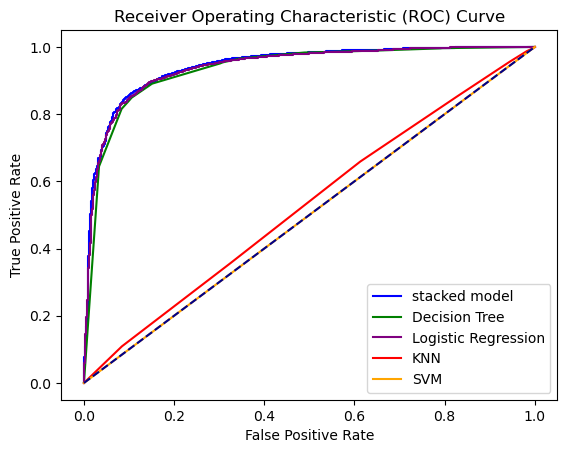

In [19]:

fprStacked, tprStacked, _ = metrics.roc_curve(y_test, yProbPred[:,1])
fprDecisionTree, tprDecisionTree, _ = metrics.roc_curve(y_test, y_Pred_DecisionTree[:,1])
fprLogisticRegression, tprLogisticRegression, _ = metrics.roc_curve(y_test, y_Pred_LogisticRegression[:,1])
fprKNN, tprKNN, _ = metrics.roc_curve(y_test, y_Pred_KNN[:,1])
fprSVM, tprSVM, _ = metrics.roc_curve(y_test, y_Pred_SVM[:,1])


plt.plot(fprStacked, tprStacked, color='blue', label = 'stacked model')
plt.plot(fprDecisionTree, tprDecisionTree, color='green', label = 'Decision Tree')
plt.plot(fprLogisticRegression, tprLogisticRegression, color='purple', label = 'Logistic Regression')
plt.plot(fprKNN, tprKNN, color='red', label = 'KNN')
plt.plot(fprSVM, tprSVM, color='orange', label = 'SVM')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
fprStacked, tprStacked, _ = metrics.roc_curve(y_test, yProbPred[:,1])
fprDecisionTree, tprDecisionTree, _ = metrics.roc_curve(y_test, y_Pred_DecisionTree[:,1])
fprLogisticRegression, tprLogisticRegression, _ = metrics.roc_curve(y_test, y_Pred_LogisticRegression[:,1])
fprKNN, tprKNN, _ = metrics.roc_curve(y_test, y_Pred_KNN[:,1])
fprSVM, tprSVM, _ = metrics.roc_curve(y_test, y_Pred_SVM[:,1])


plt.plot(fprStacked, tprStacked, color='blue', label = 'stacked model')
plt.plot(fprDecisionTree, tprDecisionTree, color='green', label = 'Decision Tree')
plt.plot(fprLogisticRegression, tprLogisticRegression, color='purple', label = 'Logistic Regression')
plt.plot(fprKNN, tprKNN, color='red', label = 'KNN')
#plt.plot(fprSVM, tprSVM, color='orange', label = 'SVM')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

plt.ylim(0, 1)
plt.xlim(0,0.15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

We can see that the stacked models is an improvement from all the base models, although it performs very closely to the level of the logistic regression mmodel.